In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
#提交样本
submission = pd.read_csv('sample_submission.csv')
# flow data
daily_data = pd.read_csv('./training_dataset/daily_dataset.csv')
hourly_data = pd.read_csv('./training_dataset/hourly_dataset.csv')
fivemin_data = pd.read_csv('./training_dataset/per5min_dataset.csv')
# other data
weather_data = pd.read_csv('./training_dataset/weather.csv')
epidemic_data = pd.read_csv('./training_dataset/epidemic.csv')
# 筛选训练数据
daily_train = daily_data[daily_data['train or test']=='train']
hourly_train = hourly_data[hourly_data['train or test']=='train']
fivemin_train = fivemin_data[fivemin_data['train or test']=='train']
weather_train = weather_data[weather_data['train or test']=='train']
epidemic_data = epidemic_data[epidemic_data['train or test']=='train']
hourly_train_new = hourly_train.reset_index(drop=True).copy()
cols = list(hourly_train_new.columns)[1:-2]
for each_col in cols:
    hourly_train_new[each_col] = hourly_train_new[each_col].apply(lambda x:x if x>0 else None)
hourly_train_new['datetime'] = hourly_train_new['time'].apply(lambda x:pd.Timestamp(x))
hourly_train_new['day'] = hourly_train_new['datetime'].apply(lambda x:x.strftime('%y%m%d'))

In [3]:
first_part_timestamp = pd.Timestamp('2022-05-01 01:00:00')
first_end_timestamp = pd.Timestamp('2022-05-08 00:00:00')
two_begin_timestamp = pd.Timestamp('2022-06-01 01:00:00')
two_end_timestamp = pd.Timestamp('2022-06-08 00:00:00')
three_begin_timestamp = pd.Timestamp('2022-07-21 01:00:00')
three_end_timestamp = pd.Timestamp('2022-07-28 00:00:00')
four_begin_timestamp = pd.Timestamp('2022-08-21 01:00:00')
four_end_timestamp = pd.Timestamp('2022-08-28 00:00:00')
hourly_train_one = hourly_train_new[hourly_train_new['datetime']<first_part_timestamp]
hourly_train_two = hourly_train_new[(hourly_train_new['datetime']>first_end_timestamp)&
                                   (hourly_train_new['datetime']<two_begin_timestamp)]
hourly_train_three = hourly_train_new[(hourly_train_new['datetime']>two_end_timestamp)&
                                   (hourly_train_new['datetime']<three_begin_timestamp)]
hourly_train_four = hourly_train_new[(hourly_train_new['datetime']>three_end_timestamp)&
                                   (hourly_train_new['datetime']<four_begin_timestamp)]
hourly_test_one = hourly_data[hourly_data['train or test']=='test1']
hourly_test_two = hourly_data[hourly_data['train or test']=='test2']
hourly_test_three = hourly_data[hourly_data['train or test']=='test3']
hourly_test_four = hourly_data[hourly_data['train or test']=='test4']

In [4]:
test_begin_list = []
test_begin_list.append(pd.Timestamp('2022-05-01 00:00:00'))
test_begin_list.append(pd.Timestamp('2022-06-01 00:00:00'))
test_begin_list.append(pd.Timestamp('2022-07-21 00:00:00'))

# 异常值处理

In [5]:
def time_window(x):
    x_value = x.values
    if len(x_value)>1:
        delta_time = (x_value[1] - x_value[0])/np.timedelta64(1, 'h')
        if delta_time>1:
            return list(x_value)
        else:
            return None
    else:
        return None

In [55]:
def anomaly_process(hourly_train_df, cols, first_hour, first_day):
    all_train_data = pd.DataFrame()
    for each_col in cols:
        # 首先检查开头是否为空
        start_time = first_hour
        flow_col = hourly_train_df[['datetime', each_col]].copy()
        flow_col_first = flow_col[flow_col['datetime']==start_time]
        if flow_col_first[each_col] is None:
            first_change = flow_col[flow_col['datetime']==(start_time+datetime.timedelta(days=1, minutes=0, seconds=0))][each_col]
            flow_col[flow_col['datetime']==start_time][each_col] = first_change
        flow_col_choose = flow_col.copy()
        flow_col_choose.index = flow_col['datetime']
        flow_col_choose = flow_col_choose[each_col].copy()
        # 判断为空的区间并补齐
        time_delta = []
        flow_col_valid = flow_col[flow_col[each_col].notnull()].copy()
        for each_w in flow_col_valid['datetime'].rolling(window=2):
            if time_window(each_w):
                time_delta.append(time_window(each_w))
        print(each_col)
        if len(time_delta)>0:
            time_delta_df = pd.DataFrame(time_delta)
            time_delta_df.columns = ['begin', 'end']
            time_delta_part = time_delta_df[~(time_delta_df['begin'].isin(test_begin_list))].reset_index(drop=True)
            for row_num, each_row in time_delta_part.iterrows():
                interval_begin = each_row['begin']
                interval_end = each_row['end']
                null_df = flow_col_choose[interval_begin:interval_end]
                day_num = (interval_end-interval_begin).days     
                for each_index in null_df.index:
                    if each_index < first_day:
                        index_after = each_index+datetime.timedelta(days=day_num+1, minutes=0, seconds=0)
                        value_after = flow_col_choose[index_after]
                        flow_col_choose[each_index] = value_after
                    else:
                        index_before = each_index-datetime.timedelta(days=day_num+1, minutes=0, seconds=0)
                        value_before = flow_col_choose[index_before]
                        flow_col_choose[each_index] = value_before
        all_train_data[each_col] = flow_col_choose
    return all_train_data

In [49]:
first_hour = pd.Timestamp('2022-01-01 01:00:00')
first_day = pd.Timestamp('2022-01-02')
all_train_one = anomaly_process(hourly_train_one, cols, first_hour, first_day)

In [50]:
first_hour_two = pd.Timestamp('2022-05-08 01:00:00')
first_day_two = pd.Timestamp('2022-05-10')
all_train_two = anomaly_process(hourly_train_two, cols, first_hour_two, first_day_two)

In [56]:
first_hour_three = pd.Timestamp('2022-06-08 01:00:00')
first_day_three = pd.Timestamp('2022-06-10')
all_train_three = anomaly_process(hourly_train_three, cols, first_hour_three, first_day_three)

flow_1
flow_2
flow_3
flow_4
flow_5
flow_6
flow_7
flow_8
flow_9
flow_10
flow_11
flow_12


KeyError: Timestamp('2022-06-05 18:00:00')

## 可视化

In [8]:
# for each_col in cols:
#     print(each_col)
#     fig = plt.figure(figsize=(16,9))
#     plt.plot(all_train_data[each_col])
#     plt.show()

In [9]:
def MSLE(y_true, y_pred):
    n = y_true.shape[0]
    log_y_true = y_true.apply(lambda x:np.log(1+x))
    log_y_pred = y_pred.apply(lambda x:np.log(1+x))
    diff_log = log_y_true - log_y_pred
    msle = diff_log.apply(lambda x:x*x).sum()/n
    return msle

In [10]:
def score(x):
    score_value = 1/(1+np.sum(msle_list))
    return score_value

## 第一次预测

In [11]:
test_one_index = list(hourly_test_one['time'].apply(lambda x:pd.Timestamp(x)))
test_one_df = hourly_test_one.copy()
test_one_df['datetime'] = test_one_df['time'].apply(lambda x:pd.Timestamp(x))
test_one_df = test_one_df[['time', 'datetime']]

In [12]:
# 循环预测
pred_df = pd.DataFrame()
for each_col in cols:
    flow_col_all = all_train_data[each_col]
    flow_col_test = pd.Series(index=test_one_index, dtype='float64')
    fh = ForecastingHorizon(flow_col_test.index, is_relative=False)
    forecaster = Prophet(
        seasonality_mode="additive",
        n_changepoints=int(len(flow_col_all) / (24*7*2)),
        add_country_holidays={"country_name": "China"},
        weekly_seasonality=True,
        daily_seasonality=True
    )

    forecaster.fit(flow_col_all)
    y_pred = forecaster.predict(fh)
    y_pred = y_pred.apply(lambda x:x if x>0 else abs(x))
    pred_df[each_col] = y_pred

15:45:37 - cmdstanpy - INFO - Chain [1] start processing
15:45:37 - cmdstanpy - INFO - Chain [1] done processing
15:45:37 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:41 - cmdstanpy - INFO - Chain [1] start processing
15:45:41 - cmdstanpy - INFO - Chain [1]

## 第二预测

In [14]:
all_train_data = pd.concat([all_train_data, pred_df])

In [17]:
test_two_index = list(hourly_test_two['time'].apply(lambda x:pd.Timestamp(x)))
test_two_df = hourly_test_two.copy()
test_two_df['datetime'] = test_two_df['time'].apply(lambda x:pd.Timestamp(x))
test_two_df = test_two_df[['time', 'datetime']]

In [18]:
# 循环预测
pred_df_two = pd.DataFrame()
for each_col in cols:
    flow_col_all = all_train_data[each_col]
    flow_col_test = pd.Series(index=test_two_index, dtype='float64')
    fh = ForecastingHorizon(flow_col_test.index, is_relative=False)
    forecaster = Prophet(
        seasonality_mode="additive",
        n_changepoints=int(len(flow_col_all) / (24*7*2)),
        add_country_holidays={"country_name": "China"},
        weekly_seasonality=True,
        daily_seasonality=True
    )

    forecaster.fit(flow_col_all)
    y_pred = forecaster.predict(fh)
    y_pred = y_pred.apply(lambda x:x if x>0 else abs(x))
    pred_df_two[each_col] = y_pred

15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing
15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:11 - cmdstanpy - INFO - Chain [1] done processing
15:52:11 - cmdstanpy - INFO - Chain [1] start processing
15:52:11 - cmdstanpy - INFO - Chain [1] done processing
15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing
15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing
15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing
15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing
15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing
15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1]

## 第三次预测

In [20]:
all_train_data = pd.concat([all_train_data, pred_df_two])
test_three_index = list(hourly_test_three['time'].apply(lambda x:pd.Timestamp(x)))
test_three_df = hourly_test_three.copy()
test_three_df['datetime'] = test_three_df['time'].apply(lambda x:pd.Timestamp(x))
test_three_df = test_three_df[['time', 'datetime']]

In [21]:
# 循环预测
pred_df_three = pd.DataFrame()
for each_col in cols:
    flow_col_all = all_train_data[each_col]
    flow_col_test = pd.Series(index=test_three_index, dtype='float64')
    fh = ForecastingHorizon(flow_col_test.index, is_relative=False)
    forecaster = Prophet(
        seasonality_mode="additive",
        n_changepoints=int(len(flow_col_all) / (24*7*2)),
        add_country_holidays={"country_name": "China"},
        weekly_seasonality=True,
        daily_seasonality=True
    )

    forecaster.fit(flow_col_all)
    y_pred = forecaster.predict(fh)
    y_pred = y_pred.apply(lambda x:x if x>0 else abs(x))
    pred_df_three[each_col] = y_pred

16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:56 - cmdstanpy - INFO - Chain [1] done processing
16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1] done processing
16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1] done processing
16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:58 - cmdstanpy - INFO - Chain [1] done processing
16:00:58 - cmdstanpy - INFO - Chain [1] start processing
16:00:58 - cmdstanpy - INFO - Chain [1] done processing
16:00:58 - cmdstanpy - INFO - Chain [1] start processing
16:00:59 - cmdstanpy - INFO - Chain [1] done processing
16:00:59 - cmdstanpy - INFO - Chain [1] start processing
16:00:59 - cmdstanpy - INFO - Chain [1] done processing
16:01:00 - cmdstanpy - INFO - Chain [1] start processing
16:01:00 - cmdstanpy - INFO - Chain [1] done processing
16:01:00 - cmdstanpy - INFO - Chain [1] start processing
16:01:00 - cmdstanpy - INFO - Chain [1]

## 第四次预测

In [23]:
all_train_data = pd.concat([all_train_data, pred_df_three])
test_four_index = list(hourly_test_four['time'].apply(lambda x:pd.Timestamp(x)))
test_four_df = hourly_test_four.copy()
test_four_df['datetime'] = test_four_df['time'].apply(lambda x:pd.Timestamp(x))
test_four_df = test_four_df[['time', 'datetime']]

pred_df_four = pd.DataFrame()
for each_col in cols:
    flow_col_all = all_train_data[each_col]
    flow_col_test = pd.Series(index=test_four_index, dtype='float64')
    fh = ForecastingHorizon(flow_col_test.index, is_relative=False)
    forecaster = Prophet(
        seasonality_mode="additive",
        n_changepoints=int(len(flow_col_all) / (24*7*2)),
        add_country_holidays={"country_name": "China"},
        weekly_seasonality=True,
        daily_seasonality=True
    )

    forecaster.fit(flow_col_all)
    y_pred = forecaster.predict(fh)
    y_pred = y_pred.apply(lambda x:x if x>0 else abs(x))
    pred_df_four[each_col] = y_pred

16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:53 - cmdstanpy - INFO - Chain [1] done processing
16:05:53 - cmdstanpy - INFO - Chain [1] start processing
16:05:53 - cmdstanpy - INFO - Chain [1] done processing
16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1] done processing
16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1]

In [24]:
pred_df_four

,flow_1,flow_2,flow_3,flow_4,flow_5,flow_6,flow_7,flow_8,flow_9,flow_10,flow_11,flow_12,flow_13,flow_14,flow_15,flow_16,flow_17,flow_18,flow_19,flow_20
2022-08-21 01:00:00,57.915434,12.522547,74.232668,45.135517,2.944308,90.158936,8.461944,2.217895,4.272755,1.627757,3.435626,1.666723,5.326212,1.823497,0.695807,3.475620,5.808298,4.541643,1.084469,2.031390
2022-08-21 02:00:00,48.040553,5.693351,57.631183,24.479514,1.482208,69.665908,3.085113,1.541874,2.010268,0.493566,1.302121,0.404821,4.383029,0.567598,0.099482,1.593469,2.606074,2.200096,0.173043,1.223309
2022-08-21 03:00:00,45.487538,3.795391,52.039438,15.148166,1.074003,64.466686,1.661043,1.397970,1.557768,0.185523,0.676979,0.012714,4.051521,0.210074,0.408434,0.906620,1.578712,1.426958,0.033403,0.978095
2022-08-21 04:00:00,48.168701,5.305078,54.440189,18.682994,1.411435,69.647922,2.977193,1.651646,2.405321,0.412312,1.080479,0.247811,4.197753,0.473574,0.268565,1.180260,2.227476,1.778419,0.220169,1.219639
2022-08-21 05:00:00,54.139041,8.738617,62.429713,30.614632,2.306640,82.375879,5.907183,2.176109,4.032720,0.909310,1.999090,0.902179,4.650773,1.063314,0.214900,2.082642,3.985494,2.837077,0.782976,1.760381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-27 20:00:00,107.753528,40.322576,144.252114,84.189628,10.256235,201.215094,31.528239,5.720010,14.952582,5.682807,11.535082,6.557978,8.814074,6.393632,3.447419,10.556529,18.132759,13.548679,5.773579,4.624568
2022-08-27 21:00:00,114.081308,46.096581,156.794985,92.453837,11.374771,216.437048,36.159922,6.209898,16.791913,6.848229,13.375069,7.759084,9.562864,7.597677,4.011287,11.882469,20.720807,15.575620,6.629239,5.147962
2022-08-27 22:00:00,109.874801,44.907392,152.904544,95.507207,10.723893,206.242877,34.907460,5.890354,16.050068,6.855612,13.129017,7.585902,9.479678,7.529865,3.872223,11.499073,20.181817,15.233393,6.243882,5.132589
2022-08-27 23:00:00,95.500704,36.370666,132.033772,88.323075,8.436721,172.437430,27.713833,4.826652,12.766525,5.560072,10.642465,6.012319,8.484974,6.086487,3.038331,9.395451,16.415424,12.435024,4.715607,4.436828


In [32]:
all_data = pd.concat([all_train_data, pred_df_four])
all_data = all_data.reset_index()
all_data

,index,flow_1,flow_2,flow_3,flow_4,flow_5,flow_6,flow_7,flow_8,flow_9,...,flow_11,flow_12,flow_13,flow_14,flow_15,flow_16,flow_17,flow_18,flow_19,flow_20
0,2022-01-01 01:00:00,29.700000,14.600000,54.700000,40.100000,3.000000,49.700000,10.900000,1.100000,5.000000,...,5.600000,2.914000,1.700000,3.200000,1.300000,3.500000,6.800000,2.902000,1.806000,1.400000
1,2022-01-01 02:00:00,21.900000,9.000000,38.000000,27.700000,2.400000,30.200000,6.400000,0.400000,2.600000,...,3.600000,1.108000,1.300000,2.200000,0.800000,2.300000,4.500000,2.269000,0.677000,0.800000
2,2022-01-01 03:00:00,16.900000,4.500000,28.900000,22.900000,1.300000,19.700000,3.800000,0.500000,1.400000,...,1.700000,0.772000,0.600000,1.500000,0.600000,1.100000,2.400000,1.055000,0.568000,0.500000
3,2022-01-01 04:00:00,14.300000,3.200000,25.500000,20.000000,1.500000,15.400000,2.700000,0.400000,1.200000,...,1.100000,0.414000,0.200000,1.200000,0.700000,0.800000,1.800000,0.677000,0.284000,0.200000
4,2022-01-01 05:00:00,14.900000,3.500000,26.400000,20.600000,1.200000,17.500000,2.200000,0.500000,1.200000,...,0.900000,0.279000,0.800000,1.100000,0.400000,0.900000,1.900000,0.891000,0.483000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2022-08-27 20:00:00,107.753528,40.322576,144.252114,84.189628,10.256235,201.215094,31.528239,5.720010,14.952582,...,11.535082,6.557978,8.814074,6.393632,3.447419,10.556529,18.132759,13.548679,5.773579,4.624568
3548,2022-08-27 21:00:00,114.081308,46.096581,156.794985,92.453837,11.374771,216.437048,36.159922,6.209898,16.791913,...,13.375069,7.759084,9.562864,7.597677,4.011287,11.882469,20.720807,15.575620,6.629239,5.147962
3549,2022-08-27 22:00:00,109.874801,44.907392,152.904544,95.507207,10.723893,206.242877,34.907460,5.890354,16.050068,...,13.129017,7.585902,9.479678,7.529865,3.872223,11.499073,20.181817,15.233393,6.243882,5.132589
3550,2022-08-27 23:00:00,95.500704,36.370666,132.033772,88.323075,8.436721,172.437430,27.713833,4.826652,12.766525,...,10.642465,6.012319,8.484974,6.086487,3.038331,9.395451,16.415424,12.435024,4.715607,4.436828


In [38]:
submission['datetime'] = submission['time'].apply(lambda x:pd.Timestamp(x))
submission_data = submission[['time', 'datetime']].merge(all_data, left_on='datetime', right_on='index', how='left')
submission_data.drop(['datetime','index'], axis=1).to_csv('submission_1107.csv')

12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing


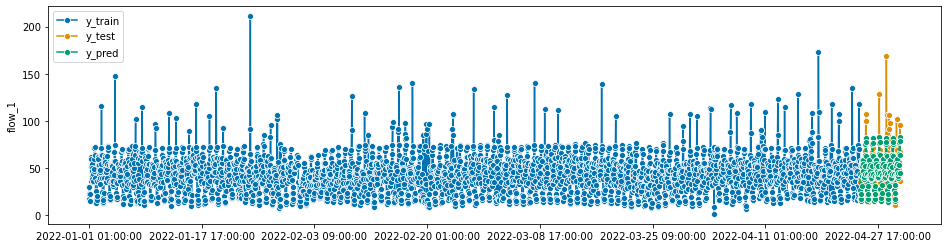

12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing


flow_1 MSLE 0.10976349509915172


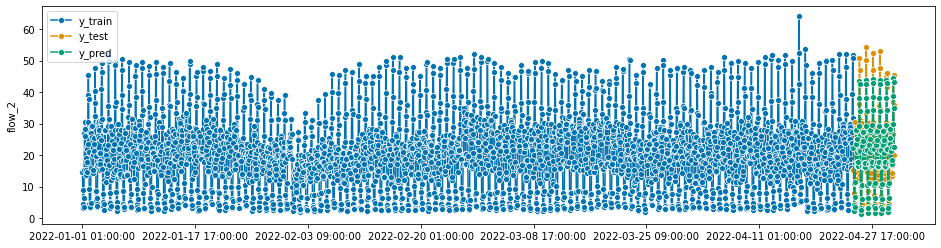

12:07:22 - cmdstanpy - INFO - Chain [1] start processing


flow_2 MSLE 0.05981211692404201


12:07:22 - cmdstanpy - INFO - Chain [1] done processing


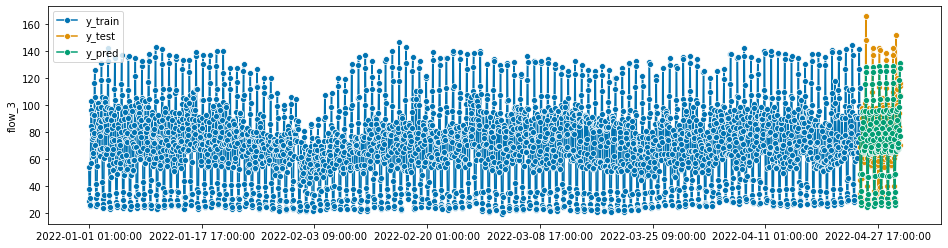

12:07:23 - cmdstanpy - INFO - Chain [1] start processing
12:07:23 - cmdstanpy - INFO - Chain [1] done processing


flow_3 MSLE 0.03984569895923305


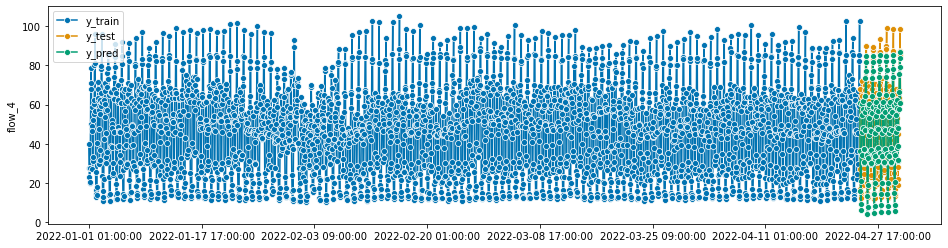

12:07:23 - cmdstanpy - INFO - Chain [1] start processing


flow_4 MSLE 0.07528784222268586


12:07:24 - cmdstanpy - INFO - Chain [1] done processing


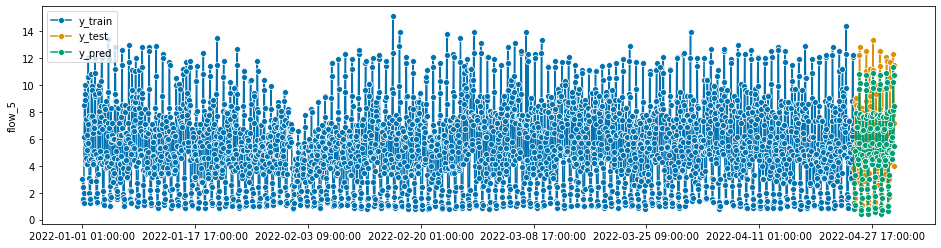

12:07:24 - cmdstanpy - INFO - Chain [1] start processing


flow_5 MSLE 0.044758364776341986


12:07:24 - cmdstanpy - INFO - Chain [1] done processing


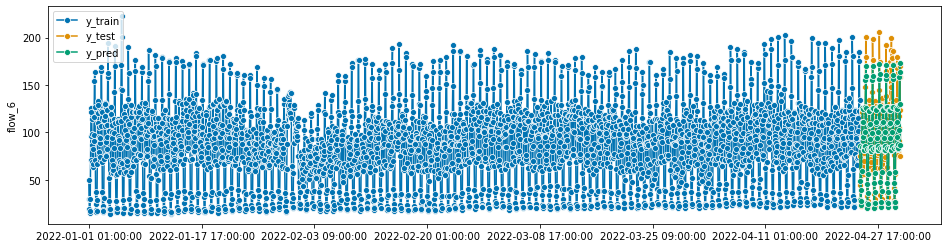

12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing


flow_6 MSLE 0.060431320195878026


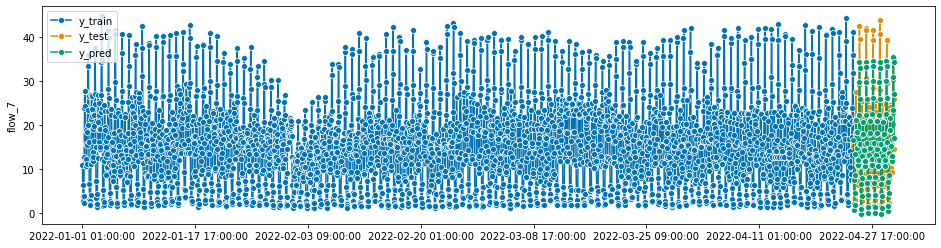

12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing


flow_7 MSLE 0.12774373571344735


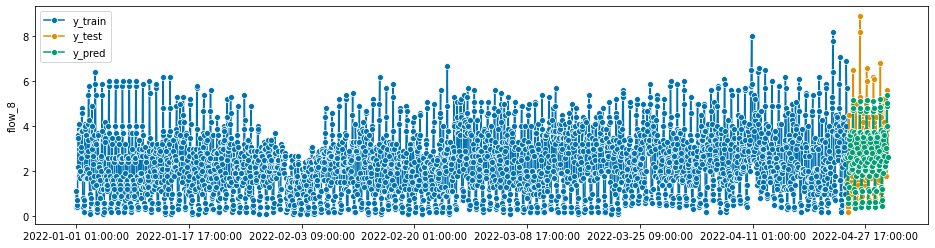

12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing


flow_8 MSLE 0.04615158373864046


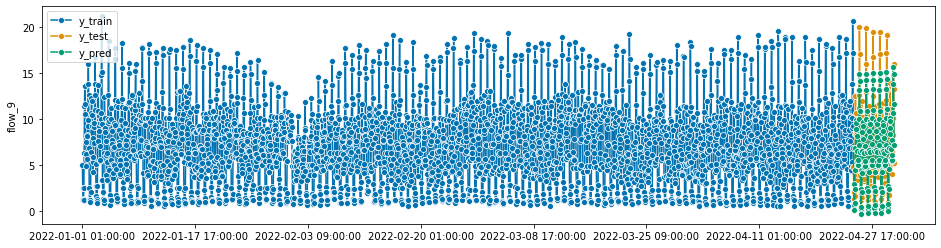

12:07:27 - cmdstanpy - INFO - Chain [1] start processing


flow_9 MSLE 0.09813587181111412


12:07:27 - cmdstanpy - INFO - Chain [1] done processing


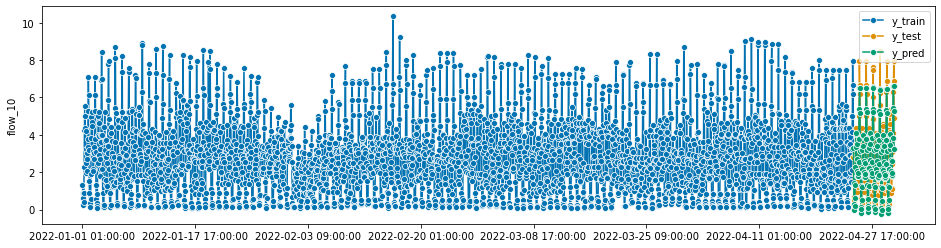

12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1] done processing


flow_10 MSLE 0.04244293179155654


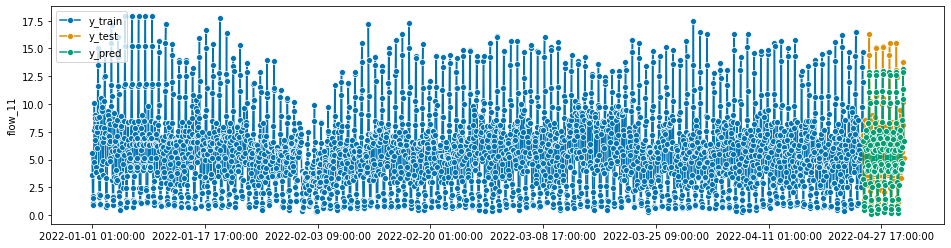

12:07:28 - cmdstanpy - INFO - Chain [1] start processing


flow_11 MSLE 0.05429574315201477


12:07:28 - cmdstanpy - INFO - Chain [1] done processing


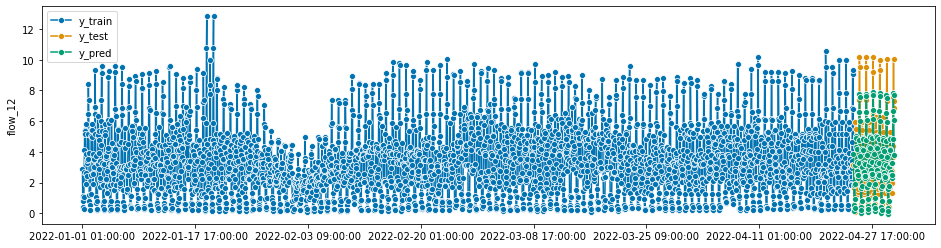

12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing


flow_12 MSLE 0.06281780632459223


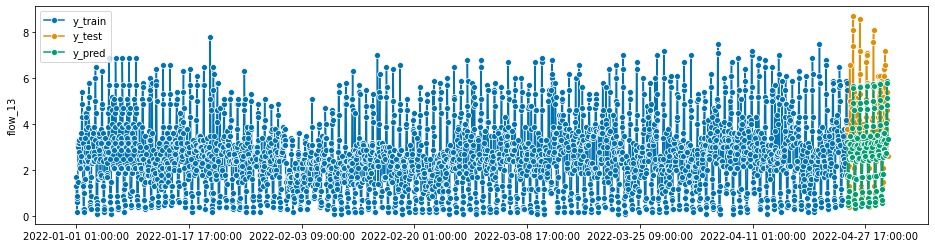

12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing


flow_13 MSLE 0.05624808583593772


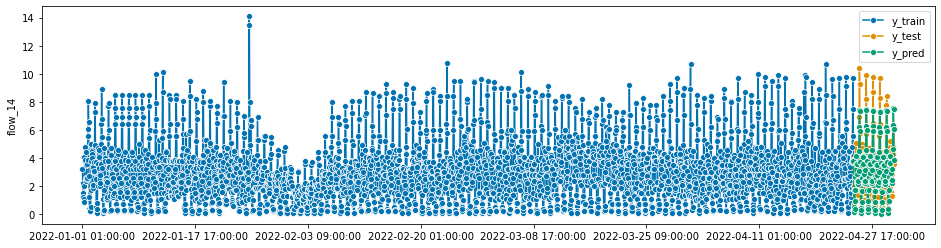

12:07:30 - cmdstanpy - INFO - Chain [1] start processing


flow_14 MSLE 0.04958552040342707


12:07:31 - cmdstanpy - INFO - Chain [1] done processing


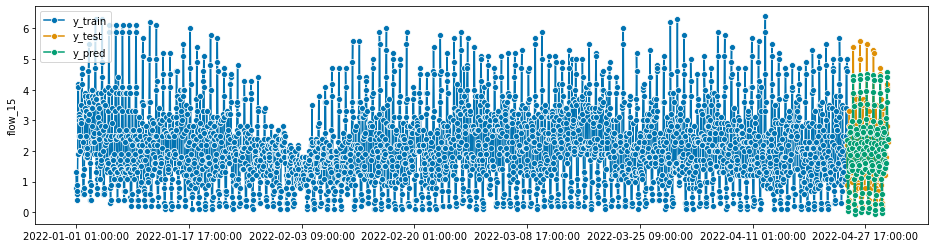

12:07:31 - cmdstanpy - INFO - Chain [1] start processing


flow_15 MSLE 0.03115792200112318


12:07:31 - cmdstanpy - INFO - Chain [1] done processing


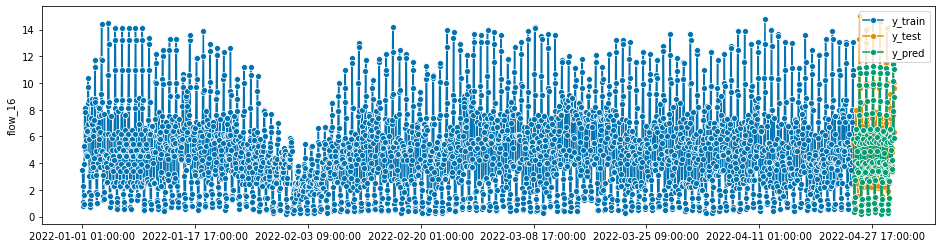

12:07:32 - cmdstanpy - INFO - Chain [1] start processing


flow_16 MSLE 0.04415060836941391


12:07:32 - cmdstanpy - INFO - Chain [1] done processing


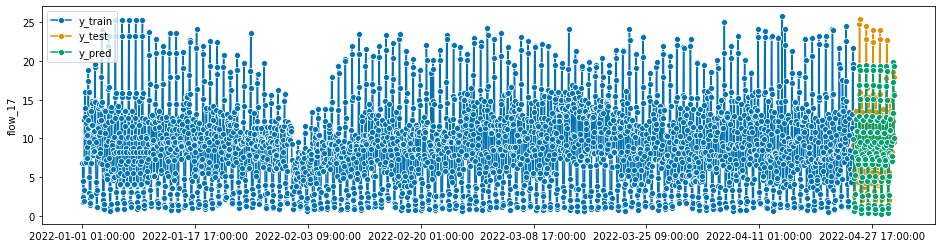

12:07:33 - cmdstanpy - INFO - Chain [1] start processing


flow_17 MSLE 0.06398342648689619


12:07:33 - cmdstanpy - INFO - Chain [1] done processing


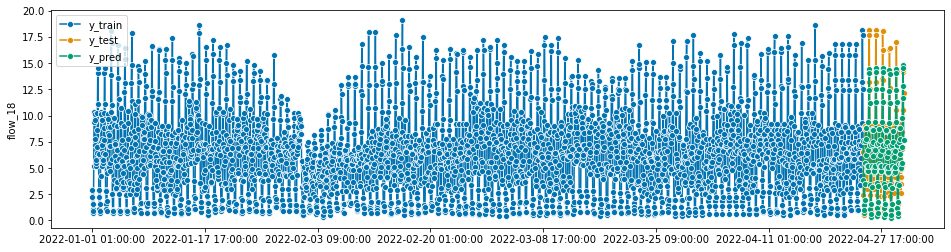

12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing


flow_18 MSLE 0.05030242258656257


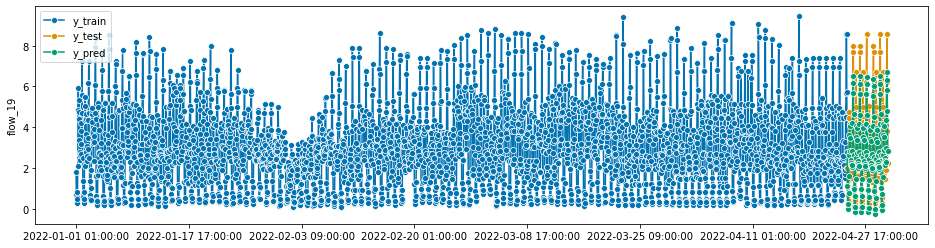

12:07:34 - cmdstanpy - INFO - Chain [1] start processing


flow_19 MSLE 0.06510231295178173


12:07:34 - cmdstanpy - INFO - Chain [1] done processing


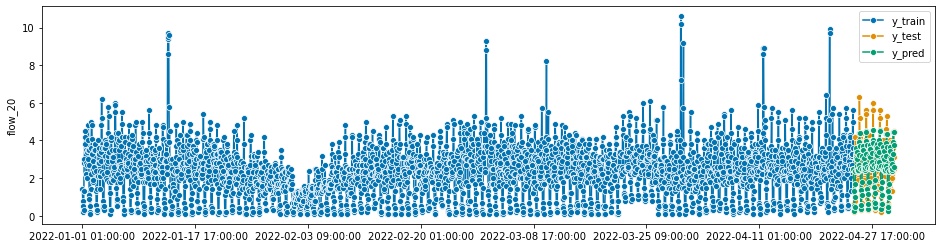

flow_20 MSLE 0.03009354952524177


In [12]:
# Prophet
msle_list = []
for each_col in cols:
    flow_col_all = all_train_data[each_col]
    end_date = pd.Timestamp('2022-04-25 00:00:00')
    test_begin = pd.Timestamp('2022-04-25 00:00:00')
    test_end = pd.Timestamp('2022-05-01 01:00:00')
    flow_col_train = flow_col_all[:end_date]
    test_index = pd.date_range(start='2022-04-25',end='2022-05-01',freq='H')
    flow_col_test = pd.Series(index=test_index, dtype='float64')
    fh = ForecastingHorizon(flow_col_test.index, is_relative=False)
    y_test = flow_col_all[test_begin:test_end]
    forecaster = Prophet(
        seasonality_mode="additive",
        n_changepoints=int(len(flow_col_train) / (24*7*2)),
        add_country_holidays={"country_name": "China"},
        weekly_seasonality=True,
        daily_seasonality=True
    )

    forecaster.fit(flow_col_train)
    y_pred = forecaster.predict(fh)
    y_pred

    plot_series(flow_col_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    plt.show()
    msle_list.append(MSLE(y_test, y_pred))
    print(each_col, 'MSLE', MSLE(y_test, y_pred))

In [13]:
score(msle_list)

0.45205701243189306